# REVES 03: Model

In this Notebook we will study the ML model to be applied as well as the best parameters to configure the final version of Reves. As a start point, we will use the DataFrame generated at the end of the second notebook.

This Notebook is structured as follows:

- Explanation of the type of model and metrics to be used
- Results for different input variables
- Explanation of results and choice of the final model
- Training of the final model and explanation

## Import data & libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
reves = pd.read_pickle("data/reves.pkl")

In [3]:
reves.head()

,directors,writers,belongs_to_collection,genres,original_language,production_companies,runtime,keywords,release_month,release_weekday,cast_names,revenue_inflated,genres_counter,production_companies_counter,main_actor_genre
0,2.669624e+08,2.669624e+08,7.092380e+07,1.059860e+08,1.188783e+08,2.669624e+08,193.0,2.269225e+08,8.272077e+07,1.408839e+08,1.759860e+08,2.669624e+08,3,1,1.539184e+08
1,1.799046e+08,1.962946e+08,7.092380e+07,1.667151e+08,1.188783e+08,1.799046e+08,105.0,1.175707e+08,1.797448e+08,9.058722e+07,1.799046e+08,1.799046e+08,4,1,1.826323e+08
2,1.298649e+08,1.298649e+08,7.092380e+07,8.279268e+07,1.188783e+08,1.298649e+08,93.0,2.149132e+08,8.251373e+07,1.279176e+08,1.468606e+08,1.298649e+08,2,1,1.539184e+08
3,7.112113e+07,7.112113e+07,7.092380e+07,8.279268e+07,1.188783e+08,4.454915e+07,68.0,1.225954e+08,5.521710e+07,8.316584e+07,4.069436e+07,3.423464e+07,2,2,1.763220e+08
4,2.919561e+06,4.166173e+06,7.092380e+07,7.353105e+07,1.188783e+08,5.839109e+06,117.0,5.842999e+07,5.521710e+07,1.691554e+08,1.052070e+07,5.839109e+06,1,1,1.763220e+08


In [4]:
reves.columns

Index(['directors', 'writers', 'belongs_to_collection', 'genres',
       'original_language', 'production_companies', 'runtime', 'keywords',
       'release_month', 'release_weekday', 'cast_names', 'revenue_inflated',
       'genres_counter', 'production_companies_counter', 'main_actor_genre'],
      dtype='object')

## Defining the value to to predict

As we said in notebook 2, we are predicting Revenue Inflated instead of Revenue. 

In [5]:
y = reves["revenue_inflated"].values
y.shape

(6441,)

## Modelling

The model we have chosen is the XGboost regressor. We think that this model is the best option because we have lots of categorical variables, and very different between them. By using sequential decision trees we think that it can give a better prediction. In addition to that, xgboos has the advantage of fast implantation.

In [6]:
from xgboost import XGBRegressor

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score

### Creation of the Function to apply the model

Once we have stablished the type of algorithm we want to use, we should try different approaches to find the best parameters for the final model. 

First, we have to decide the input data: what columns/features we are using for the model. Are we using all of them? Is the model better without any of them? For that purpose, we are creating a function that takes an input data, divides data in subsets, trains model and prints the key metrics. This way, just by applying this function to different datasets we will be able to easyly compare different iterations of the model.

We will plot the mean absolute error (mae) and the root mean squared error (rmse). We provide an array of X and y pairs to the eval_metric argument when fitting our XGBoost model. In addition to a test set, we can also provide the training dataset. This will provide a report on how well the model is performing on both training and test sets during training.


This function returns 4 metrics:

* Mean Absolute Error
* Explained Variance Score
* Score
* Cross Validation Score

For these versions, the model always has the same parameters:
* n_estimators = 250
* max_depth = 3

We do not perform GridSearchCV because it would slow down the execution of the notebook a lot. For now, we are just comparing versions only chanching the input data. Once we have decided the input data that works best, we will optimize the model by using GridSearchCV.

In [8]:
def model_train(input_data):
    
    # definition input data and creation of the Train-Test-split.
    X = train.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
    
    # training and definition of the evaluated data (train and test)
    xgbo = XGBRegressor(n_estimators = 250, max_depth = 3)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgbo.fit(X_train, y_train, eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=False)

    # make predictions for test data
    y_pred = xgbo.predict(X_test)

    # evaluate predictions
    error = mean_absolute_error(y_test, y_pred)
    variance_score = explained_variance_score(y_pred, y_test)
    score = xgbo.score(X_test, y_test)
    cross_val = cross_val_score(xgbo, X, y, cv = 10).mean()

    # retrieve performance metrics
    results = xgbo.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    # plot mae
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['mae'], label='Train')
    ax.plot(x_axis, results['validation_1']['mae'], label='Test')
    ax.legend()
    plt.ylabel('mae')
    plt.title('XGBoost mae')
    plt.show()

    # plot rmse
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    plt.ylabel('rmse')
    plt.title('XGBoost rmse')
    plt.show()
    
    return (error, variance_score, score, cross_val)

#### Start empty DataFrame that will collect all the results

In [9]:
xgbo_results = pd.DataFrame(columns = ["experiment", "mean_absolute_error", "explained_variance_score", "score", "cross_val_score"])

#### Version 0 - All Features

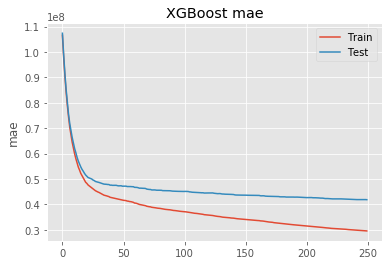

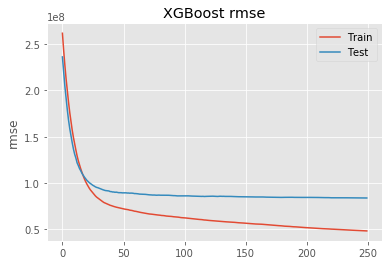

Mean Absolute Error= 41845634.07 
Explained Variance Score = 0.830750 
Score = 0.862327 
Cross Val Score = 0.779014


In [10]:
train = reves.drop(["revenue_inflated"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# saving the results in a dataframe
experiment = "All Features"
number_experiment = 0
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 1 - No genres counter

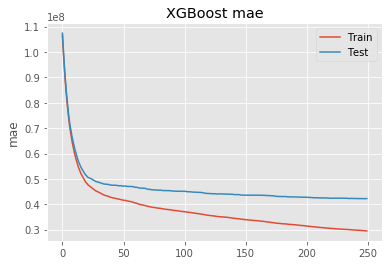

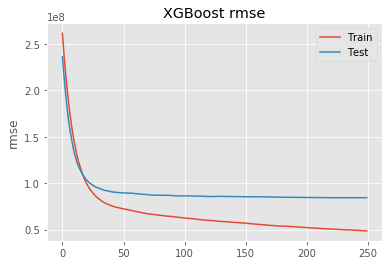

Mean Absolute Error= 42256726.60 
Explained Variance Score = 0.828316 
Score = 0.860964 
Cross Val Score = 0.780163


In [11]:
train = reves.drop(["revenue_inflated", "genres_counter"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# saving the results in a dataframe
experiment = "No Genres Counter"
number_experiment = 1
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 2 - No writers

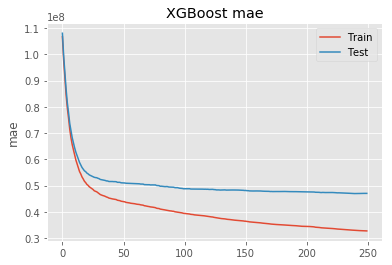

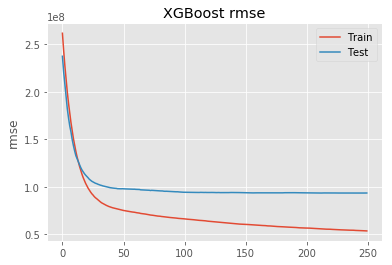

Mean Absolute Error= 47011407.09 
Explained Variance Score = 0.780929 
Score = 0.829481 
Cross Val Score = 0.775567


In [12]:
train = reves.drop(["revenue_inflated", "writers"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# saving the results in a dataframe
experiment = "No Writers"
number_experiment = 2
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 3 - No original language

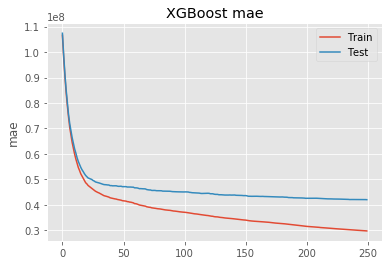

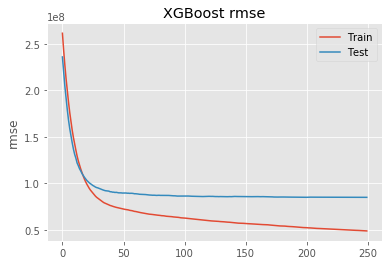

Mean Absolute Error= 42052488.91 
Explained Variance Score = 0.826147 
Score = 0.859351 
Cross Val Score = 0.780175


In [13]:
train = reves.drop(["revenue_inflated", "original_language"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# saving the results in a dataframe
experiment = "No Original Language"
number_experiment = 3
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 4 - No release weekday

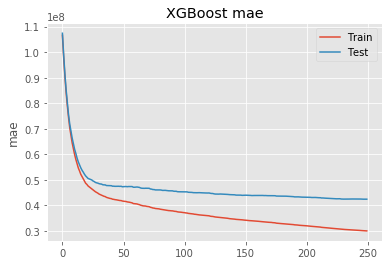

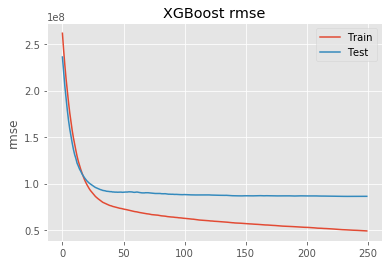

Mean Absolute Error= 42464477.29 
Explained Variance Score = 0.820128 
Score = 0.854274 
Cross Val Score = 0.779773


In [14]:
train = reves.drop(["revenue_inflated", "release_weekday"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# saving the results in a dataframe
experiment = "No Release Weekday"
number_experiment = 4
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 5 - No release month

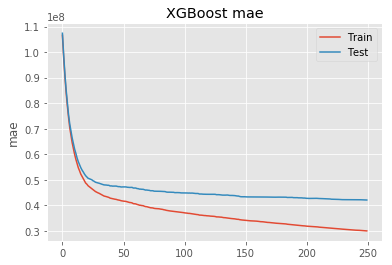

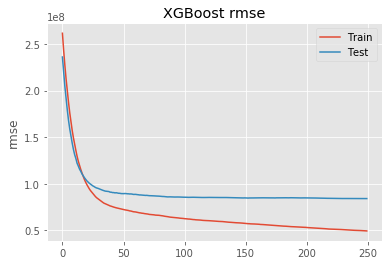

Mean Absolute Error= 42049640.24 
Explained Variance Score = 0.829635 
Score = 0.862224 
Cross Val Score = 0.782320


In [15]:
train = reves.drop(["revenue_inflated", "release_month"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# saving the results in a dataframe
experiment = "No Release Month"
number_experiment = 5
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 6 - No production companies counter

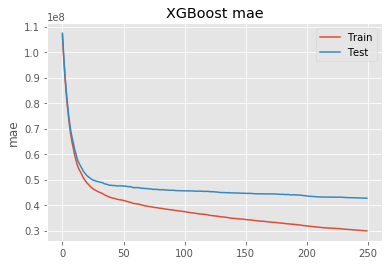

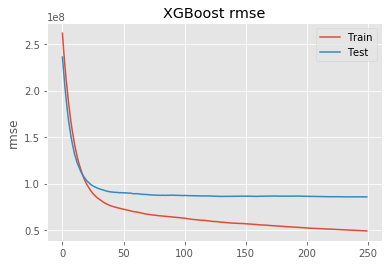

Mean Absolute Error= 42664113.80 
Explained Variance Score = 0.818041 
Score = 0.856237 
Cross Val Score = 0.782015


In [16]:
train = reves.drop(["revenue_inflated", "production_companies_counter"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# saving the results in a dataframe
experiment = "No Number of Production Companies"
number_experiment = 6
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 7 - No Main Actor's Genre

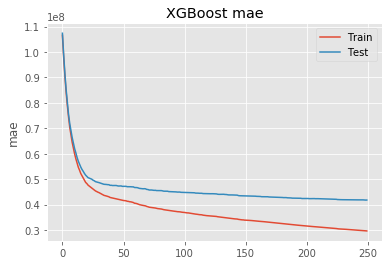

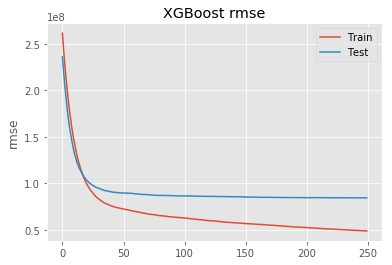

Mean Absolute Error= 41779910.59 
Explained Variance Score = 0.829137 
Score = 0.861047 
Cross Val Score = 0.780481


In [17]:
train = reves.drop(["revenue_inflated", "main_actor_genre"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# saving the results in a dataframe
experiment = "No Main Actor's Genre"
number_experiment = 7
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 8 - No runtime

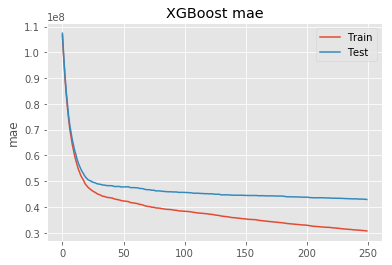

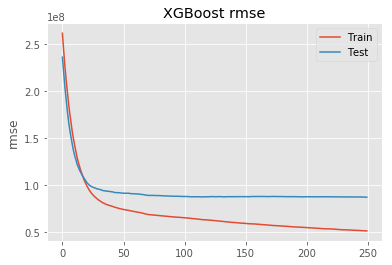

Mean Absolute Error= 42901433.83 
Explained Variance Score = 0.818018 
Score = 0.852713 
Cross Val Score = 0.775490


In [18]:
train = reves.drop(["revenue_inflated", "runtime"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# saving the results in a dataframe
experiment = "No Runtime"
number_experiment = 8
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 9. No Genres Counter and No Main Actor's Genre

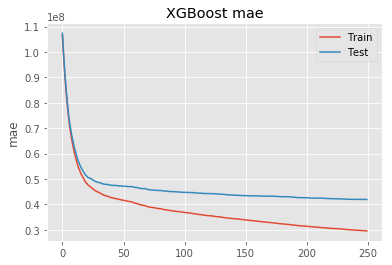

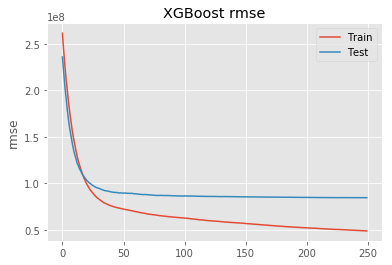

Mean Absolute Error= 41930587.06 
Explained Variance Score = 0.828183 
Score = 0.860358 
Cross Val Score = 0.780753


In [19]:
train = reves.drop(["revenue_inflated", "genres_counter", "main_actor_genre"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# saving the results in a dataframe
experiment = "No Genres Counter and No Main Actor's Genre"
number_experiment = 9
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

##   Models Comparison

In [20]:
xgbo_results

,experiment,mean_absolute_error,explained_variance_score,score,cross_val_score
0,All Features,4.184563e+07,0.830750,0.862327,0.779014
1,No Genres Counter,4.225673e+07,0.828316,0.860964,0.780163
2,No Writers,4.701141e+07,0.780929,0.829481,0.775567
3,No Original Language,4.205249e+07,0.826147,0.859351,0.780175
4,No Release Weekday,4.246448e+07,0.820128,0.854274,0.779773
5,No Release Month,4.204964e+07,0.829635,0.862224,0.782320
6,No Number of Production Companies,4.266411e+07,0.818041,0.856237,0.782015
7,No Main Actor's Genre,4.177991e+07,0.829137,0.861047,0.780481
8,No Runtime,4.290143e+07,0.818018,0.852713,0.775490
9,No Genres Counter and No Main Actor's Genre,4.193059e+07,0.828183,0.860358,0.780753


The first conclusion to point out is that we can see by a quick glance that all graphs of mae and rmse look quite similar in all the experiments we've run. The train and the test learn fast (50 epochs), but we will see later with GridSearchCV which are the most recommended values.

We can also check that the metrics are very similar in all the experiments, except in the case where there were no scriptwriters that is worse: without this variable the error is greater. Based on this we decided to train the model for all the variables and not discard any since it is the test with the highest score.

## Final Model

Now that we know that the best version of Reves is when we use all the features available in our dataframe, and that therefore we have identified the best input data, we have to play with xgboos parameters to optimize the model's results.

In order to do that we will:

- Use GridsearchCV to select the best values to our model.
- Train the model with the whole dataset and plot the features importance.
- Save the model in a pickle file in order to use it later in our webapp.

In [21]:
X = reves.drop(["revenue_inflated"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
xgbo = GridSearchCV(estimator = XGBRegressor(),
                    param_grid = {"n_estimators" : np.arange(200, 500, 50), "max_depth" : np.arange(3, 6, 1)})
xgbo.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([200, 250, 300, 350, 400, 450]), 'max_depth': array([3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
print(xgbo.best_params_)

{'max_depth': 3, 'n_estimators': 400}


In the first part of the modeling process we used 50 epoch to compare different versions of the model. Looking at the graphs above, we could think by the errors that perhaps the optimal parameter of number of estimators was close to 50.

Nevertheless, by using GridSearchCV we have inquired that the best epoch values is 400.

### Final training and evaluation

Now let's train the model with all the data and visualize in a plot which variables are more important / have more relevance for the model.

In [23]:
xgbo = XGBRegressor(n_estimators = 400, max_depth = 3)
xgbo.fit(X, y)
# make predictions for test data
y_pred = xgbo.predict(X_test)

# evaluate predictions
print(mean_absolute_error(y_test, y_pred))
print(explained_variance_score(y_pred, y_test))
print(xgbo.score(X_test, y_test))
print(cross_val_score(xgbo, X, y, cv = 10).mean())

29715379.95372
0.9507864605328741
0.9545966853070289
0.7796376923052251


First let's look at the first decision tree and see what it does.

In [28]:
from xgboost import to_graphviz

In [29]:
to_graphviz(xgbo, rankdir = "LR", num_trees = 0)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

We see for this first tree the model starts by evaluating the value of the scriptwriters and then combines with the value of the keywords and directors.

For this task we see there are three options for measuring feature importance in XGBoost:

* Weight. The number of times a feature is used to split the data across all trees.
* Gain. The average training loss reduction gained when using a feature for splitting.
* Cover. The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.

This explanation is based in this web: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

In [30]:
from xgboost import plot_importance

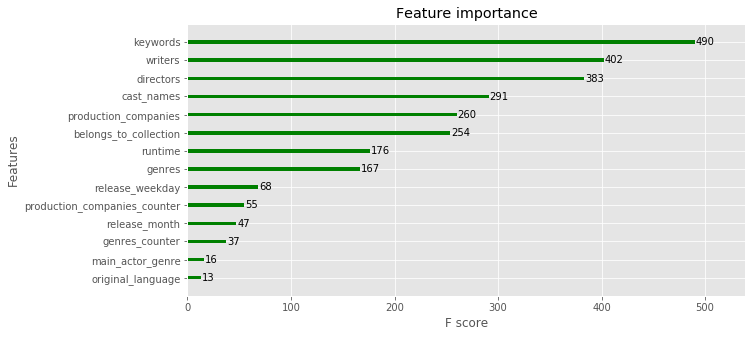

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgbo, ax = ax, importance_type = "weight", color = "green")
plt.show()

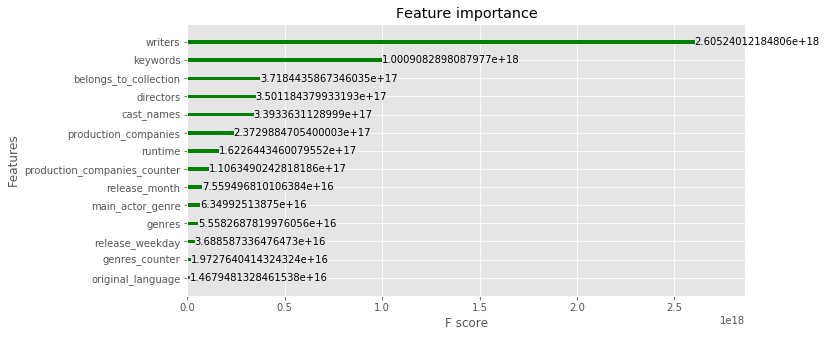

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgbo, ax = ax, importance_type = "gain", color = "green")
plt.show()

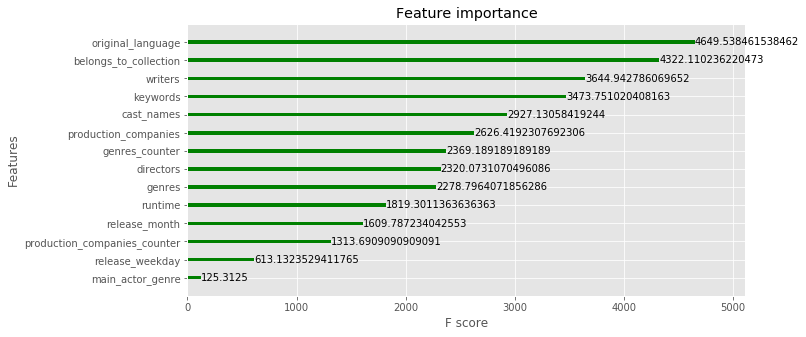

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgbo, ax = ax, importance_type = "cover", color = "green")
plt.show()

We can notice that the feature importance order differs depending on the metric that we use.

For the cover method it seems like the original_language feature is most relevant for revenue prediction. However, this feature is the worst or least important in the other two options (gain & weight), where scriptwriters, keywords, directors o belongs_to_collection seem to gain relevance for the model above other features.

In order to take into account consistency and accuracy we use the shap library.

In [34]:
import shap

ModuleNotFoundError: No module named 'shap'

In [35]:
shap.initjs()
explainer = shap.TreeExplainer(xgbo)
shap_values = explainer.shap_values(X)

NameError: name 'shap' is not defined

In [36]:
shap.summary_plot(shap_values, X)

NameError: name 'shap' is not defined

In [37]:
shap.summary_plot(shap_values, X, plot_type = "bar", color = "green")

NameError: name 'shap' is not defined

Seems like most important features are the scriptwriters, followed by keywords and directors.

To know more about this type of graphs, check https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

## Save the model in a pickle file

During this notebook we have fit the model taking into account the names of the columns with the purpose to plot those names in the graphs. In order to avoid problems using the model on a production enviroment, we will train again the model using the whole datasted and without these keys.

In [38]:
X = reves.drop(["revenue_inflated"], axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
xgbo = XGBRegressor(n_estimators = 400, max_depth = 3)
xgbo.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [39]:
print(mean_absolute_error(y_test, y_pred))
print(explained_variance_score(y_pred, y_test))
print(xgbo.score(X_test, y_test))

29715379.95372
0.9507864605328741
0.9545966853070289


In [40]:
import pickle
pickle.dump(xgbo, open("xgbo_model.pkl", "wb"))

## Next steps

Now that Reves has born as a model, the next step of the project will be using it at a real production enviroment. For that, we have developed a webapp using HTML, CSS and Flask. 

You can run the app on the internet by accesing our web https://revesapp.herokuapp.com/

You can also download all the files from out Github repo to run the app in a local enviroment. https://github.com/ElsaDuran/reves

And if you want to easily take a look at all the data processing we've used for back-end without opening the app's files, you can go to the next notebook: http://localhost:8888/notebooks/Documents/GitHub/reves/04.Reves_to_production.ipynb